### Initialise

In [111]:
## Import necessary packages
import matplotlib.pyplot as plt; 
import pandas as pd; 
import numpy as np; 

from sklearn.model_selection import train_test_split,cross_val_score;
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
import xgboost as xg

import python.data as datameta

def rd(a):
    return round(a,4)
def mse(a,b):
    err = rd(mean_squared_error(a,b)); 
    return err; 
def mae(a,b):
    err = rd(mean_absolute_error(a,b)); 
    return err; 
def r2(a,b):
    err = rd(r2_score(a,b)); 
    return err; 

### Preprocess Data

In [112]:
data = datameta.processData('data/clean_data.csv'); 
data.head()

Index(['Time (h)', 'Aeration rate(Fg:L/h)', 'Sugar feed rate(Fs:L/h)',
       'Acid flow rate(Fa:L/h)', 'Base flow rate(Fb:L/h)',
       'Air head pressure(pressure:bar)', 'Substrate concentration(S:g/L)',
       'Penicillin concentration(P:g/L)', 'Vessel Volume(V:L)', 'pH(pH:pH)',
       'Temperature(T:K)', 'PAA flow(Fpaa:PAA flow (L/h))',
       'Oil flow(Foil:L/hr)', 'Ammonia shots(NH3_shots:kgs)', 'Water Flow'],
      dtype='object') 

 (113935, 15)


,Time (h),Aeration rate(Fg:L/h),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Air head pressure(pressure:bar),Substrate concentration(S:g/L),Penicillin concentration(P:g/L),Vessel Volume(V:L),pH(pH:pH),Temperature(T:K),PAA flow(Fpaa:PAA flow (L/h)),Oil flow(Foil:L/hr),Ammonia shots(NH3_shots:kgs),Water Flow
0,0.000000,0.181818,0.040541,0.000000,0.133858,0.0,0.008306,1.791808e-27,0.049276,0.767126,0.258427,0.333333,0.0,0.0,0.004470
1,0.000690,0.181818,0.040541,0.000000,0.227649,0.0,0.008715,2.763729e-05,0.049480,0.800686,0.249064,0.333333,0.0,0.0,0.008252
2,0.001380,0.181818,0.040541,0.000000,0.241342,0.0,0.009107,2.761905e-05,0.049685,0.836653,0.243446,0.333333,0.0,0.0,0.004363
3,0.002070,0.181818,0.040541,0.000000,0.168071,0.0,0.009492,2.760247e-05,0.049787,0.860582,0.237828,0.333333,0.0,0.0,0.001972
4,0.002761,0.181818,0.040541,0.039866,0.084036,0.0,0.009864,2.758782e-05,0.049838,0.865835,0.234082,0.333333,0.0,0.0,0.000502


In [113]:
# Split into x and y
xkeys = [
    "Time (h)", "Aeration rate(Fg:L/h)", "Sugar feed rate(Fs:L/h)","Acid flow rate(Fa:L/h)",
    "Base flow rate(Fb:L/h)","Water Flow","Substrate concentration(S:g/L)","PAA flow(Fpaa:PAA flow (L/h))",
    "Oil flow(Foil:L/hr)", "Ammonia shots(NH3_shots:kgs)",
    # Converted variables
    "Air head pressure(pressure:bar)", "Temperature(T:K)", "pH(pH:pH)", "Vessel Volume(V:L)"
]
(x,y) = datameta.xy_split(data,xkeys)
xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.1)
ytest = ytest.to_numpy().flatten(); 

x:  14  keys in  14 cols
y:  1  keys in  1 cols


In [114]:
# TESTING OUT ALL TYPES
def row(name,ytest, yhat):
    return [name, r2(ytest, yhat),mae(ytest, yhat),mse(ytest, yhat)]

# BASIC MODELS
# models = [
#     LinearRegression(), 
#     DecisionTreeRegressor(), 
#     SGDRegressor(loss='squared_error')
# ]

# for index,model in enumerate(models):
#     model.fit(xtrain, ytrain.values.ravel()); 
#     models[index] = row(model.__class__.__name__, ytest, model.predict(xtest))

# models = pd.DataFrame(models, columns=["","R2 Sq","MAE", "MSE"]); 
# models.style.highlight_max(color='#4f4').highlight_min(color='#f44'); 
# models

,,R2 Sq,MAE,MSE
0,LinearRegression,0.9726,0.0331,0.0021
1,DecisionTreeRegressor,0.9946,0.0074,0.0004
2,SGDRegressor,0.9698,0.0352,0.0023


In [115]:
models=[
    GradientBoostingRegressor(), 
    xg.XGBRFRegressor(),
    RandomForestRegressor()
]

for index,model in enumerate(models):
    mod = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
    mod.fit(xtrain, ytrain.values.ravel()); 
    yhat = mod.predict(xtest)

    models[index] = row(model.__class__.__name__, ytest, mod.predict(xtest))

models = pd.DataFrame(models, columns=["","R2 Sq","MAE", "MSE"]); 
models.style.highlight_max(color='#4f4').highlight_min(color='#f44'); 
models

,,R2 Sq,MAE,MSE
0,GradientBoostingRegressor,0.9853,0.0233,0.0011
1,XGBRFRegressor,0.9793,0.0270,0.0016
2,RandomForestRegressor,0.9973,0.0076,0.0002


In [116]:
# dt = DecisionTreeRegressor(); 
# dt.fit(xtrain, ytrain); 

# ypred = dt.predict(xtest); 
# print("TEST:\n",ytest,"\nPRED:\n", ypred)

TEST:
 [0.0094456  0.52626926 0.7540005  ... 0.61061823 0.6689606  0.83144015] 
PRED:
 [0.01195479 0.52513611 0.75704062 ... 0.60998261 0.64737582 0.8342039 ]


In [117]:
# def isClose(base, known):
#     return np.abs((base - known) / base) <= 0.001

# accuracy = np.sum(isClose(ypred, ytest))/len(ytest)
# print(rd(accuracy*100), "%")

19.6156 %


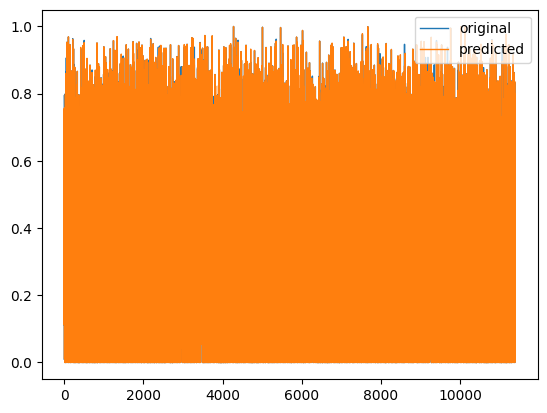

In [118]:

# xax = range(len(ytest))
# plt.plot(xax, ytest, linewidth=1, label="original")
# plt.plot(xax, ypred, linewidth=1, label="predicted")
# plt.legend(loc='best')
# plt.show() 
